In [40]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（同じ縮退ペア間のみ）
w3 = 0.2      # 3体相互作用（全てのトリプレット間）

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義（フェルミ符号を含む） ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン ====
pairs = [(0,1), (2,3), (4,5)]
H2 = np.zeros((dim, dim))

for (a,b) in pairs:
    for i, s in enumerate(basis):
        # 密度項（両方占有）
        if s[a] == 1 and s[b] == 1:
            H2[i, i] += v

        # 交換項 a→b
        if s[a] == 1 and s[b] == 0:
            s2, sign = apply_cdag_c(s, b, a)
            if s2 in basis:
                j = basis.index(s2)
                H2[i, j] += v * sign

        # 交換項 b→a（逆方向も入れる）
        if s[b] == 1 and s[a] == 0:
            s2, sign = apply_cdag_c(s, a, b)
            if s2 in basis:
                j = basis.index(s2)
                H2[i, j] += v * sign

# ==== 3体ハミルトニアン ====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

# 全ての triplet → triplet 結合を入れる
for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            # T2をすべて占有している場合のみ作用
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # まず T2 をアニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # 次に T1 を作る
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = (H + H.conj())/2# Hermitize（実対称に）

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

Hamiltonian matrix (dim=20):
[[1.5 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.2 0.
  0.  0.2]
 [0.3 1.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  2.3 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.3 2.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  2.3 0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  3.  0.3 0.3 0.  0.  0.  0.3 0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 3.  0.  0.3 0.  0.  0.  0.3 0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 0.  3.  0.3 0.  0.  0.  0.  0.3 0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.3 3.  0.  0.  0.  0.  0.  0.3 0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  4.3 0.  0.  0.  0.  0.  0.3 0.  0.
  0.  0. ]
 [0.2 0.  0.  0.  0.3 0.  0.  0.  0.  0.  2.5 0.  0.  0.  0.  0.  0.2 0.
  0.  0.2]
 [0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.  0.  3

In [ ]:
import itertools
import numpy as np

# ==== 全基底（64次元） ====
all_basis = [tuple(int(x) for x in format(i, '06b')) for i in range(2**6)]

# ==== 3粒子空間の基底インデックスを求める ====
basis_index = [all_basis.index(b) for b in basis]

# ==== 20次元→64次元への埋め込み ====
H_full = np.zeros((64, 64), dtype=complex)
for i, bi in enumerate(basis_index):
    for j, bj in enumerate(basis_index):
        H_full[bi, bj] = H[i, j]

# ==== パウリ行列定義 ====
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
paulis = [I, X, Y, Z]
labels = ['I','X','Y','Z']

# ==== Pauli 展開 ====
coeffs = {}
for ops in itertools.product(range(4), repeat=6):
    P = paulis[ops[0]]
    for k in ops[1:]:
        P = np.kron(P, paulis[k])
    c = np.trace(P @ H_full) / 64
    if abs(c) > 1e-8:
        label = ''.join(labels[k] for k in ops)
        coeffs[label] = np.real_if_close(c)

# ==== 出力 ====
print(f"\nNonzero Pauli terms ({len(coeffs)} terms):")
for k, v in sorted(coeffs.items(), key=lambda x: -abs(x[1])):
    print(f"{k:10s} : {v:.6f}")



Nonzero Pauli terms (300 terms):
IIIIII     : 1.006250
ZZZZZZ     : -1.006250
IIZIIZ     : -0.218750
IZIIZI     : -0.218750
IZZIZZ     : 0.218750
ZIIZII     : -0.218750
ZIZZIZ     : 0.218750
ZZIZZI     : 0.218750
IIZIZI     : -0.212500
IZIIIZ     : -0.212500
ZIZZZI     : 0.212500
ZZIZIZ     : 0.212500
IZIZII     : -0.212500
ZIZIZZ     : 0.212500
IZZZIZ     : 0.212500
ZIIIZI     : -0.212500
IZZZZI     : 0.206250
ZIIIIZ     : -0.206250
IZIZZZ     : 0.206250
ZIZIII     : -0.206250
IIIZIZ     : -0.206250
ZZZIZI     : 0.206250
IZZIII     : -0.200000
ZIIZZZ     : 0.200000
IIIZZI     : -0.200000
ZZZIIZ     : 0.200000
IZZZZZ     : -0.193750
ZIIIII     : 0.193750
IIIIZI     : -0.187500
IZIIII     : 0.187500
ZIZZZZ     : -0.187500
ZZZZIZ     : 0.187500
IIIIIZ     : -0.181250
ZZZZZI     : 0.181250
IIZZII     : -0.168750
ZZIIZZ     : 0.168750
IIIIZZ     : -0.162500
ZZZZII     : 0.162500
IIZZZZ     : 0.162500
ZZIIII     : -0.162500
IIZIZZ     : 0.125000
ZZIZII     : -0.125000
IIIZZZ     : 0.125000

In [42]:
# ==== 出力ファイルに書き出し ====
output_file = "pauli_expansion.txt"

with open(output_file, "w") as f:
    f.write("# Pauli expansion of the 6-qubit Hamiltonian\n")
    f.write("# Format: PauliString   Coefficient (real)\n\n")
    for k, v in sorted(coeffs.items(), key=lambda x: -abs(x[1])):
        f.write(f"{k:10s} {v:.10f}\n")

print(f"\nPauli expansion written to: {output_file}")



Pauli expansion written to: pauli_expansion.txt


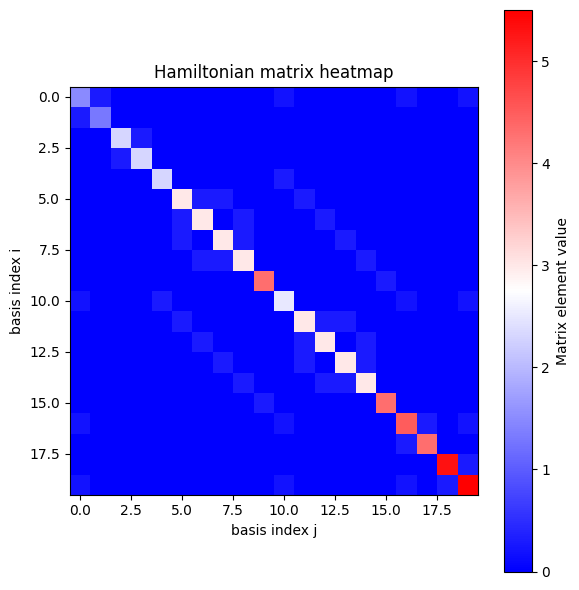

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(H, cmap="bwr", interpolation="nearest")
plt.colorbar(label="Matrix element value")
plt.title("Hamiltonian matrix heatmap")
plt.xlabel("basis index j")
plt.ylabel("basis index i")
plt.tight_layout()
plt.show()

In [48]:
import itertools
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper

# --- 前のHを使う ---
# Hは20×20の行列
dim = H.shape[0]
N_orb = 6  # 軌道数

# --- Basis 生成（3粒子/6軌道） ---
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(N_orb, 3)

# --- FermionicOp用に辞書を作成 ---
terms = {}
for i, bra in enumerate(basis):
    for j, ket in enumerate(basis):
        coeff = H[i, j]
        if abs(coeff) < 1e-12:
            continue

        ops = []
        for k in range(N_orb):
            if bra[k] == 1 and ket[k] == 0:
                ops.append(f"+_{k}")
            elif bra[k] == 0 and ket[k] == 1:
                ops.append(f"-_{k}")

        label = ' '.join(ops) if ops else ""  # 恒等項は空文字
        terms[label] = terms.get(label, 0.0) + coeff

fermionic_ham = FermionicOp(terms, num_spin_orbitals=N_orb)


# --- FermionicOp 生成 ---
fermionic_ham = FermionicOp(terms, num_spin_orbitals=N_orb)

# --- Jordan-Wigner変換 ---
mapper = JordanWignerMapper()
qubit_ham = mapper.map(fermionic_ham)

# --- 結果表示 ---
print("=== Fermionic Hamiltonian ===")
print(fermionic_ham)

print("\n=== Pauli-encoded Hamiltonian ===")
print(qubit_ham)



=== Fermionic Hamiltonian ===
Fermionic Operator
number spin orbitals=6, number terms=19
  64.39999999999999
+ 1.8 * ( +_2 -_3 )
+ 0.2 * ( +_0 -_3 )
+ 0.2 * ( +_0 +_1 -_3 -_4 )
+ 0.2 * ( +_0 +_1 +_2 -_3 -_4 -_5 )
+ 1.8 * ( -_2 +_3 )
+ 1.8 * ( +_4 -_5 )
+ 1.8 * ( -_4 +_5 )
+ 1.8 * ( +_0 -_1 )
+ 0.2 * ( -_0 +_3 )
+ 1.8 * ( -_0 +_1 )
+ 0.2 * ( +_1 -_4 )
+ 0.2 * ( +_1 +_2 -_4 -_5 )
+ 0.2 * ( -_0 -_1 +_3 +_4 )
+ 0.2 * ( -_1 +_4 )
+ 0.2 * ( +_2 -_5 )
+ 0.2 * ( -_0 -_1 -_2 +_3 +_4 +_5 )
+ 0.2 * ( -_1 -_2 +_4 +_5 )
+ 0.2 * ( -_2 +_5 )

=== Pauli-encoded Hamiltonian ===
SparsePauliOp(['IIIIII', 'IIXYII', 'IIYXII', 'IIXZZY', 'IIYZZX', 'IXYIXY', 'IYXIXY', 'IYYIYY', 'IXXIYY', 'IYYIXX', 'IXXIXX', 'IXYIYX', 'IYXIYX', 'XYXYXY', 'YXXYXY', 'YYYYXY', 'XXYYXY', 'YYXXXY', 'XXXXXY', 'XYYXXY', 'YXYXXY', 'YYXYYY', 'XXXYYY', 'XYYYYY', 'YXYYYY', 'XYXXYY', 'YXXXYY', 'YYYXYY', 'XXYXYY', 'YYXYXX', 'XXXYXX', 'XYYYXX', 'YXYYXX', 'XYXXXX', 'YXXXXX', 'YYYXXX', 'XXYXXX', 'XYXYYX', 'YXXYYX', 'YYYYYX', 'XXYYYX', 'YYXXYX

In [49]:
import numpy as np

# qubit_ham は Jordan-Wigner 変換後の SparsePauliOp
# 量子ビット数
n_qubits = 6

# 数値行列に変換
H_matrix = qubit_ham.to_matrix()

# 確認
np.set_printoptions(precision=3, suppress=True)
print("Pauli変換後の行列 (dim={}):".format(H_matrix.shape[0]))
print(H_matrix)

# 固有値も計算可能
eigvals = np.linalg.eigvalsh(H_matrix)
print("\nEigenvalues:")
print(np.round(eigvals, 4))


Pauli変換後の行列 (dim=64):
[[64.4+0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j -0. +0.j]
 [ 0. +0.j 64.4+0.j  1.8+0.j ...  0. +0.j -0. +0.j  0. +0.j]
 [ 0. +0.j -1.8+0.j 64.4+0.j ...  0. +0.j  0. +0.j  0. +0.j]
 ...
 [ 0. +0.j  0. +0.j -0. +0.j ... 64.4+0.j  1.8+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j ... -1.8+0.j 64.4+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j 64.4+0.j]]

Eigenvalues:
[58.982 60.682 60.682 60.688 60.688 60.988 60.988 62.286 62.307 62.4
 62.4   62.4   62.452 62.691 62.691 62.691 62.691 62.691 62.691 62.714
 62.868 62.911 64.039 64.039 64.076 64.076 64.299 64.299 64.4   64.4
 64.4   64.4   64.4   64.4   64.527 64.527 64.536 64.536 64.646 64.646
 64.679 64.679 65.761 66.103 66.109 66.109 66.109 66.109 66.109 66.109
 66.161 66.297 66.37  66.4   66.4   66.4   66.571 67.827 67.827 68.106
 68.106 68.108 68.108 69.817]
